In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from glob import glob

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44271,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:46545,Total threads: 4
Dashboard: /proxy/40329/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:39643,


### Read in data, define sessions and experiments etc. 

In [3]:
master_session = cc.database.create_session()
control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice  = slice(-80,-59)

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [6]:
#runoff_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sum('yt_ocean').load()

In [7]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
area_t=area_t.rename({"xt_ocean": "lon", "yt_ocean": "lat"})
#lon = cc.querying.getvar(Tfreezing_min_calv_2, 'x', basal_melt_session, n=1)
#lat = cc.querying.getvar(Tfreezing_min_calv_2, 'y', basal_melt_session, n=1)

In [8]:
from netCDF4 import Dataset as nc

nc_icb_file = "/home/552/pc5520/forcing_files/ICB/Iceberg_Interannual_Merino.nc"
ncfile_icb = nc(nc_icb_file,'r')
icbflux = ncfile_icb.variables['Icb_flux'][:,:,:]
lon_icb = ncfile_icb.variables['longitude'][:,:]
lat_icb = ncfile_icb.variables['latitude'][:,:]
ncfile_icb.close()

#NEMO GRID
nemo_grid_file = "/home/552/pc5520/forcing_files/ICB/cut_ORCA025_coordinates.nc"
nemo_grid = nc(nemo_grid_file,'r')
nav_lon = nemo_grid.variables['nav_lon'][:,:]
nav_lat = nemo_grid.variables['nav_lat'][:,:]
e1t = nemo_grid.variables['e1t'][0,:,:]
e2t = nemo_grid.variables['e2t'][0,:,:]
nemo_grid.close()

In [9]:
#nemo_grid = xr.open_dataset("/home/552/pc5520/forcing_files/ICB/cut_ORCA025_coordinates.nc",decode_cf=False)
#nemo_grid

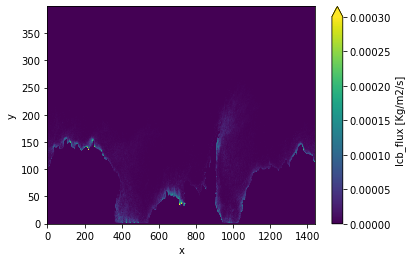

In [10]:
ds = xr.open_dataset('/home/552/pc5520/forcing_files/ICB/Iceberg_Interannual_Merino.nc')
ds.Icb_flux[0,:,:].plot(vmin=0., vmax=0.0003)
plt.show()

In [11]:
# Calculate mass (flux x area)
icb_mass = icbflux * 0
for tt in range(icb_mass.shape[0]):
    icb_mass[tt,:,:] = icbflux[tt,:,:] * e1t[:,:] * e2t[:,:]

# Regridding ------------------------

In [12]:
ht = cc.querying.getvar(control, 'ht', master_session, n=-1).load()
hu = cc.querying.getvar(control, 'hu', master_session, n=-1).load()

### Bilinear

In [13]:
# create access grid (ds_out)
access_grid_out = cc.querying.getvar(control, 'temp', master_session, n=1).isel(st_ocean=0).squeeze().load()
access_grid_out = access_grid_out.rename({"xt_ocean": "lon", "yt_ocean": "lat"})
#access_grid_out

In [14]:
# create iceberg grid (ds_in)
# The way it's formatted is not useful for xesmf
lats = ds.latitude[:,0].values
lons = ds.longitude[0,1:-1].values
months = ds.month.values
icb_flux = ds.Icb_flux[:,:,1:-1].values

da = xr.DataArray(data=icb_flux,
                  dims=["month","lat", "lon"],
                  coords=dict(lon=lons,
                              lat=lats,
                              month=months,),
                  attrs=dict(description="Iceberg Flux",
                             units="Kg/m2/s",),
                 )

# extract longitude values
lons_in = da.lon.values
print(lons_in.shape)
#lons_in[428] #= -180.
lons_in[1148] = 0.

# extract longtiude values, and replace those > 80 so that it matches model lons
lons_in[lons_in >= 80] = lons_in[lons_in >= 80]-360

# create new longitude array from -280 to 80. 
new_lons_in = np.sort(np.concatenate((lons_in[28:],lons_in[:28]))) # sorted lon
print(new_lons_in.shape)
# now concatenate fluxes so that it goes from -280 to 80 like model data
da = xr.concat((da[:,:,28:], da[:,:,0:28]), dim='lon')
# reassign lon as the newly ordered lon array 
# (otherwise matplotlib complains that x dimension is not sorted in increasing manner)
da["lon"] = new_lons_in

# convert data array to dataset
di = da.to_dataset(name='Icb_flux')
di

(1440,)
(1440,)


<xarray.Dataset>
Dimensions:   (lon: 1440, lat: 400, month: 12)
Coordinates:
  * lon       (lon) float32 -280.0 -279.8 -279.5 -279.2 ... 79.25 79.5 79.75
  * lat       (lat) float32 -77.01 -76.95 -76.9 -76.84 ... -24.47 -24.24 -24.01
  * month     (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    Icb_flux  (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [15]:
%%time
# Create regridder and save to file
regridder = xe.Regridder(di, access_grid_out, 'bilinear')
access_bilinear = regridder.to_netcdf('access_bilinear.nc')

CPU times: user 1min 28s, sys: 5.25 s, total: 1min 33s
Wall time: 1min 27s


In [17]:
%%time
# Read in regridder
regridder = xe.Regridder(di, access_grid_out, 'bilinear', periodic=True,
                         reuse_weights=True, filename = 'access_bilinear.nc')

# apply to dataset
icb_flux_regrid_bi = regridder(di)

CPU times: user 3.33 s, sys: 762 ms, total: 4.09 s
Wall time: 5.39 s


In [18]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            access_bilinear.nc 
Reuse pre-computed weights? True 
Input grid shape:           (400, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [19]:
# multiply by area to get mass/s in each box
icb_mass_regrid_bi = area_t.T*icb_flux_regrid_bi

#print ratio of regridded mass integrated over domain vs merino mass integrated over domain for each month
for i in np.arange(12):
    print((icb_mass_regrid_bi.isel(month = i).Icb_flux.sum()/icb_mass[i,:,:].sum()).values)



0.9912251
0.9909631
0.99104756
0.99080765
0.9911199
0.9913988
0.991312
0.99141586
0.9914162
0.9914765
0.9915185
0.9913256


### Conservative 

Cannot get xesmf to recognise the `periodic=True` option. It just seems to ignore it. 

In [20]:
access_grid_out = cc.querying.getvar(control, 'temp', master_session, n=1).isel(st_ocean=0).squeeze().load()
access_grid_out = access_grid_out.rename({"xt_ocean": "lon", "yt_ocean": "lat"})
# convert access_grid_out to dataset
access_grid_out = access_grid_out.to_dataset()

# add lon and lat bounds required for conservative regridding.
u = cc.querying.getvar(control, 'u', master_session, n=1)
access_lonu = u.xu_ocean.values
access_latu = u.yu_ocean.values
access_lonu = np.concatenate(([-280.], access_lonu))
access_latu = np.concatenate(([-81.129], access_latu))
access_grid_out['lon_b'] = access_lonu
access_grid_out['lat_b'] = access_latu
access_grid_out#.rename({"longitude": "lon", "latitude": "lat"})

<xarray.Dataset>
Dimensions:   (lon: 3600, lat: 2700, lon_b: 3601, lat_b: 2701)
Coordinates:
  * lon       (lon) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * lat       (lat) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
    st_ocean  float64 0.5413
    time      object 1900-02-15 00:00:00
  * lon_b     (lon_b) float64 -280.0 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * lat_b     (lat_b) float64 -81.13 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    temp      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [23]:
# reorder iceberg_flux dataset 
# current set up is not useful/recognised easily by xesmf
# dataset should be cf compliant, and if not requires some extra info

lats = ds.latitude[:,0].values
lons = ds.longitude[0,1:-1].values
months = ds.month.values
icb_flux = ds.Icb_flux[:,:,1:-1].values

da = xr.DataArray(data=icb_flux,
                  dims=["month","lat", "lon"],
                  coords=dict(lon=lons,
                              lat=lats,
                              month=months,),
                  attrs=dict(description="Iceberg Flux",
                             units="Kg/m2/s",),
                 )

# extract longitude values
lons_in = da.lon.values
print(lons_in.shape)
#lons_in[428] #= -180.
lons_in[1148] = 0.

# extract longtiude values, and replace those > 80 so that it matches model lons
lons_in[lons_in >= 80] = lons_in[lons_in >= 80]-360

# create new longitude array from -280 to 80. 
new_lons_in = np.sort(np.concatenate((lons_in[28:],lons_in[:28]))) # sorted lon
print(new_lons_in.shape)
# now concatenate fluxes so that it goes from -280 to 80 like model data
da = xr.concat((da[:,:,28:], da[:,:,0:28]), dim='lon')
# reassign lon as the newly ordered lon array 
# (otherwise matplotlib complains that x dimension is not sorted in increasing manner)
da["lon"] = new_lons_in

di = da.to_dataset(name='Icb_flux')

(1440,)
(1440,)


In [24]:
# Now read in u and v data from same ORCA grid. 
# We will use these to create the lon_b and lat_b variables 
# required for conservative regridding (when the ds is not cf compliant 
# with exisiting bounds that can be read by xe).

oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'
oras5_Ufiles = sorted(glob(oras5_data_path+f'vozocrtx/opa*/vozocrtx_*.nc')) 
oras5_Vfiles = sorted(glob(oras5_data_path+f'vomecrty/opa*/vomecrty_*.nc')) 
oras5_Uref = xr.open_dataset(oras5_Ufiles[0])
oras5_Vref = xr.open_dataset(oras5_Vfiles[0])
oras5_Uref
# replace x and y indices with equivalent lat and lons
latu, lonu = oras5_Uref.nav_lat[:,0].values[0:400], oras5_Uref.nav_lon[0,:].values
latv, lonv = oras5_Vref.nav_lat[:,0].values[0:400], oras5_Vref.nav_lon[0,:].values
lonu = lonu[1:]
# Concatenate lonu so it matches di.lon
lonu = np.concatenate((lonu[28:], lonu[:28]))
lonu[lonu>=80] = lonu[lonu>=80]-360

# make it nlon+1 and nlat+1 dimensions
latv = np.concatenate(([-77.066], latv))

# now add to dataset
di = di.assign_coords(coords={"lon_b":lonu, "lat_b":latv})
di

<xarray.Dataset>
Dimensions:   (lon: 1440, lat: 400, month: 12, lon_b: 1441, lat_b: 401)
Coordinates:
  * lon       (lon) float32 -280.0 -279.8 -279.5 -279.2 ... 79.25 79.5 79.75
  * lat       (lat) float32 -77.01 -76.95 -76.9 -76.84 ... -24.47 -24.24 -24.01
  * month     (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lon_b     (lon_b) float32 -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * lat_b     (lat_b) float64 -77.07 -76.98 -76.93 ... -24.36 -24.13 -23.9
Data variables:
    Icb_flux  (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [25]:
%%time
# save regridder to file
regridder = xe.Regridder(di, access_grid_out, 'conservative', periodic=True, ignore_degenerate=True)
access_conservative = regridder.to_netcdf('access_conservative.nc')

CPU times: user 3min 20s, sys: 13.6 s, total: 3min 34s
Wall time: 3min 18s


In [27]:
regridder = xe.Regridder(di, access_grid_out, 'conservative', periodic=True,
                         reuse_weights=True, filename='access_conservative.nc')
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            access_conservative.nc 
Reuse pre-computed weights? True 
Input grid shape:           (400, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      False

In [31]:
%%time
icb_flux_regrid_cons = regridder(di.Icb_flux)


CPU times: user 914 ms, sys: 64.3 ms, total: 978 ms
Wall time: 914 ms


In [33]:
# multiply by area to get mass/s in each box
icb_mass_regridded_cons = area_t*icb_flux_regrid_cons

#print ratio of regridded mass integrated over domain vs merino mass integrated over domain for each month
for i in np.arange(12):
    print((icb_mass_regridded_cons.isel(month = i).sum()/icb_mass[i,:,:].sum()).values)


0.9911264
0.9912236
0.9913181
0.9913128
0.99129194
0.9913282
0.9913442
0.99137026
0.9914125
0.9915183
0.99163395
0.99120945


### Conservative normed

In [34]:
%%time
# save regridder to file
regridder = xe.Regridder(di, access_grid_out, 'conservative_normed', periodic=True, ignore_degenerate=True)
access_conservative_periodic = regridder.to_netcdf('access_conservative_normed.nc')

CPU times: user 3min 7s, sys: 8.29 s, total: 3min 16s
Wall time: 3min 1s


In [35]:
regridder = xe.Regridder(di, access_grid_out, 'conservative_normed', periodic=True, 
                         reuse_weights=True, filename='access_conservative_normed.nc')
regridder

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            access_conservative_normed.nc 
Reuse pre-computed weights? True 
Input grid shape:           (400, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      False

In [36]:
%%time
# apply regridder to iceberg flux dataset
icb_flux_regrid_cons_norm = regridder(di.Icb_flux)

# multiply by area to get mass/s in each box
icb_mass_regridded_cons_norm = area_t*icb_flux_regrid_cons_norm

#print ratio of regridded mass integrated over domain vs merino mass integrated over domain for each month
for i in np.arange(12):
    print((icb_mass_regridded_cons_norm.isel(month = i).sum()/icb_mass[i,:,:].sum()).values)



0.9912799
0.9914303
0.9915157
0.99158007
0.9914674
0.9914561
0.99148405
0.9914898
0.9915391
0.99164116
0.99174726
0.99133193
CPU times: user 7.61 s, sys: 1.05 s, total: 8.66 s
Wall time: 23.6 s


### Conservative normed with mask

This option captures even less of original flux (~98%) than the other methods. It seems like xesmf is not moving fluxes under mask to adjacent unmasked cells, hence the larger discrepancy. 

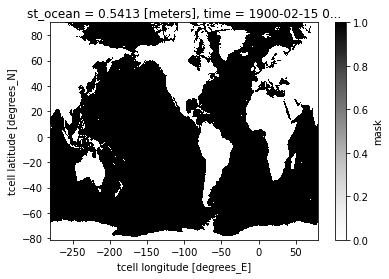

In [153]:
# Add mask variable to access grid
access_grid_out["mask"] = xr.where(~np.isnan(access_grid_out["temp"]), 1, 0)
access_grid_out.mask.plot(cmap='Greys')

In [108]:
%%time
# save regridder to file
regridder = xe.Regridder(di, access_grid_out, 'conservative_normed', periodic=True, ignore_degenerate=True)
access_conservative_periodic = regridder.to_netcdf('access_conservative_normed_mask.nc')

CPU times: user 3min 6s, sys: 6.16 s, total: 3min 12s
Wall time: 3min 5s


In [109]:
regridder = xe.Regridder(di, access_grid_out, 'conservative_normed', periodic=True, 
                         reuse_weights=True, filename='access_conservative_normed_mask.nc')
regridder

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            access_conservative_normed_periodic_mask.nc 
Reuse pre-computed weights? True 
Input grid shape:           (400, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      False

In [110]:
%%time
icb_flux_regrid_cons_norm_mask = regridder(di.Icb_flux)

# multiply by area to get mass/s in each box
icb_mass_regridded_cons = area_t*icb_flux_regrid_cons_norm_mask
icb_mass_regridded_cons

#print ratio of regridded mass integrated over domain vs merino mass integrated over domain for each month
for i in np.arange(12):
    print((icb_mass_regridded_cons.isel(month = i).sum()/icb_mass[i,:,:].sum()).values)



0.97120816
0.9737321
0.9758353
0.9793583
0.97966236
0.97896564
0.9783795
0.97927094
0.97948676
0.97953486
0.9795919
0.9711564
CPU times: user 5.99 s, sys: 1 s, total: 6.99 s
Wall time: 18.5 s


### Save regridded iceberg fluxes to file

In [42]:
outdir = '/g/data/e14/hd4873/model_data/access-om2/basal_melt_MOM5/'

# bilinear
icb_flux_regrid_bi.attrs['units']="kg/m2/s"
icb_flux_regrid_bi.to_netcdf(outdir+'Merino_icb_flux_regridded_bilinear.nc')

# conservative
icb_flux_regrid_cons.attrs['units']="kg/m2/s"
ds = xr.Dataset({'Icb_flux':icb_flux_regrid_cons})
ds.to_netcdf(outdir+'Merino_icb_flux_regridded_conservative.nc')

# conservative normed
icb_flux_regrid_cons_norm.attrs['units']="kg/m2/s"
ds = xr.Dataset({'Icb_flux':icb_flux_regrid_cons_norm})
ds.to_netcdf(outdir+'Merino_icb_flux_regridded_conservative_normed.nc')

In [136]:
regridder = xe.Regridder(di, access_grid_out, 'conservative', periodic=True, 
                         reuse_weights=True, filename='access_conservative_periodic_mask.nc')
regridder

2022-12-17 12:35:24,396 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-12-17 12:35:25,674 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-12-17 12:35:27,162 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            access_conservative_periodic_mask.nc 
Reuse pre-computed weights? True 
Input grid shape:           (400, 1440) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      False

In [124]:
%%time
icb_flux_access_cons = regridder(di.Icb_flux)

# multiply by area to get mass/s in each box
icb_mass_regridded_cons = area_t*icb_flux_access_cons
icb_mass_regridded_cons

#print ratio of regridded mass integrated over domain vs merino mass integrated over domain for each month
for i in np.arange(12):
    print((icb_mass_regridded_cons.isel(month = i).sum()/icb_mass[i,:,:].sum()).values)




0.9710547
0.97352535
0.9756377
0.97909105
0.9794868
0.97883767
0.9782396
0.9791513
0.9793602
0.97941196
0.9794788
0.971034
CPU times: user 6.22 s, sys: 727 ms, total: 6.94 s
Wall time: 18.1 s


### Plotting

In [43]:
httmp = ht.copy(deep=True)
httmp = (ht*0).fillna(1)

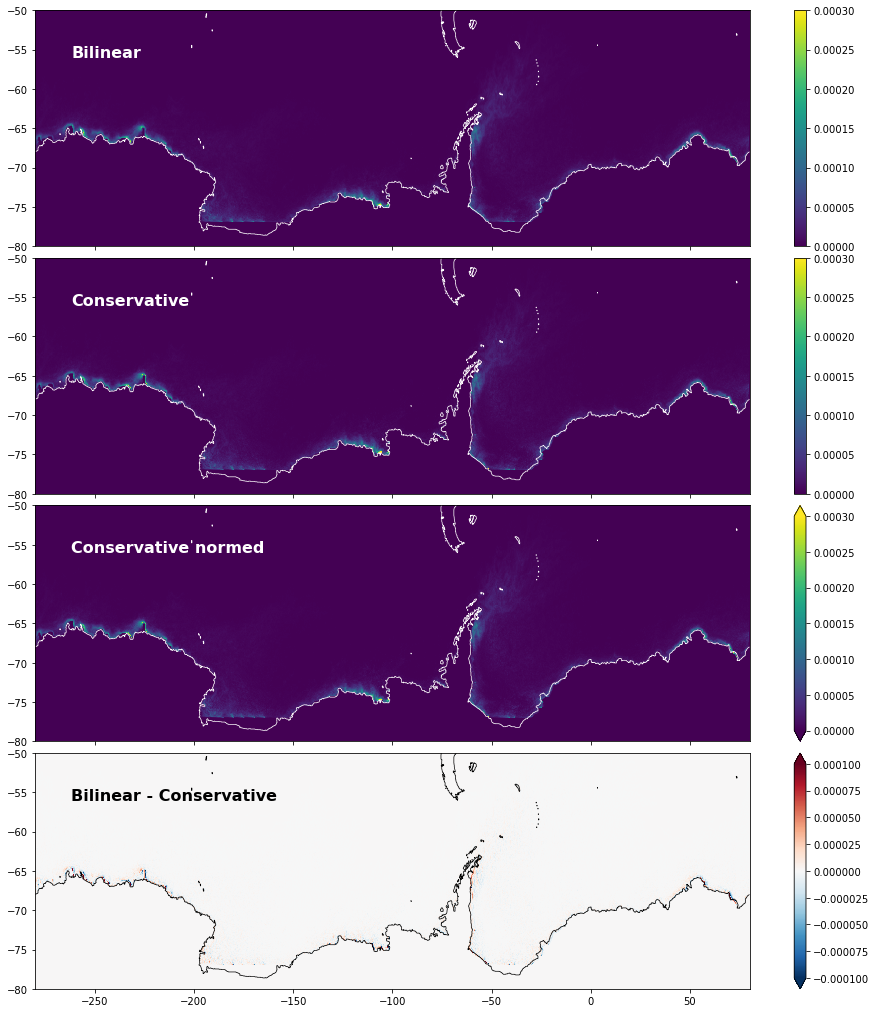

In [49]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,18), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
month = 0
labels = ['Bilinear',
          'Conservative',
          'Conservative normed',
          'Bilinear - Conservative']

cb = axes[0].pcolormesh(icb_flux_regrid_bi.lon, icb_flux_regrid_bi.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[0].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[0].text(0.05, 0.8, labels[0], c='w', fontweight='bold',fontsize=16., transform=axes[0].transAxes)
fig.colorbar(cb, ax=axes[0])

cb = axes[1].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_cons[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[1].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[1].text(0.05, 0.8, labels[1], c='w', fontweight='bold',fontsize=16., transform=axes[1].transAxes)
fig.colorbar(cb, ax=axes[1])

cb = axes[2].pcolormesh(icb_flux_regrid_cons_norm.lon, icb_flux_regrid_cons_norm.lat, 
                        icb_flux_regrid_cons_norm[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[2].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[2].text(0.05, 0.8, labels[2], c='w', fontweight='bold',fontsize=16., transform=axes[2].transAxes)
fig.colorbar(cb, ax=axes[2], extend='both')

cb = axes[3].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:]-icb_flux_regrid_cons[month,:,:], 
                        vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')
axes[3].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='k', linewidths=0.7)
axes[3].text(0.05, 0.8, labels[3], c='k', fontweight='bold',fontsize=16., transform=axes[3].transAxes)
fig.colorbar(cb, ax=axes[3], extend='both')

axes[0].set_ylim([-80, -50])
plt.show()

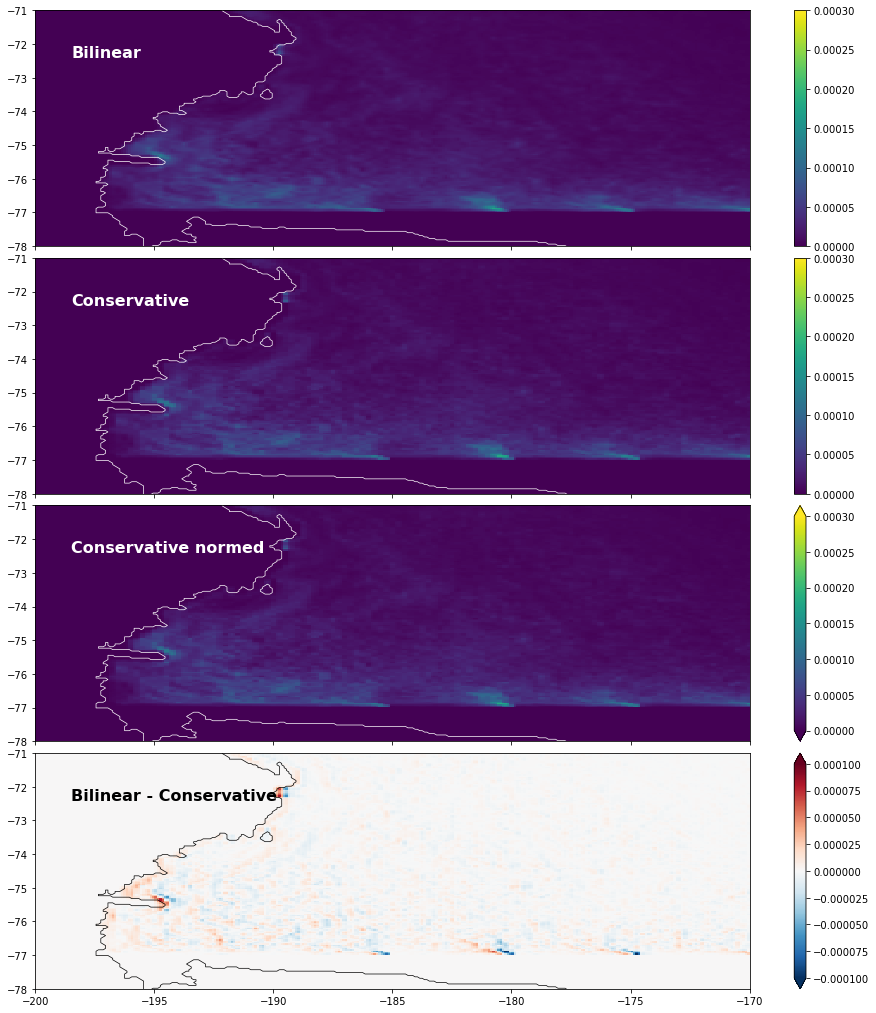

In [50]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,18), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
month = 0

cb = axes[0].pcolormesh(icb_flux_regrid_bi.lon, icb_flux_regrid_bi.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[0].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[0].text(0.05, 0.8, labels[0], c='w', fontweight='bold',fontsize=16., transform=axes[0].transAxes)
fig.colorbar(cb, ax=axes[0])

cb = axes[1].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_cons[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[1].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[1].text(0.05, 0.8, labels[1], c='w', fontweight='bold',fontsize=16., transform=axes[1].transAxes)
fig.colorbar(cb, ax=axes[1])

cb = axes[2].pcolormesh(icb_flux_regrid_cons_norm.lon, icb_flux_regrid_cons_norm.lat, 
                        icb_flux_regrid_cons_norm[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[2].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[2].text(0.05, 0.8, labels[2], c='w', fontweight='bold',fontsize=16., transform=axes[2].transAxes)
fig.colorbar(cb, ax=axes[2], extend='both')

cb = axes[3].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:]-icb_flux_regrid_cons[month,:,:], 
                        vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')
axes[3].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='k', linewidths=0.7)
axes[3].text(0.05, 0.8, labels[3], c='k', fontweight='bold',fontsize=16., transform=axes[3].transAxes)
fig.colorbar(cb, ax=axes[3], extend='both')

axes[0].set_ylim([-78, -71])
axes[0].set_xlim([-200, -170])
plt.show()

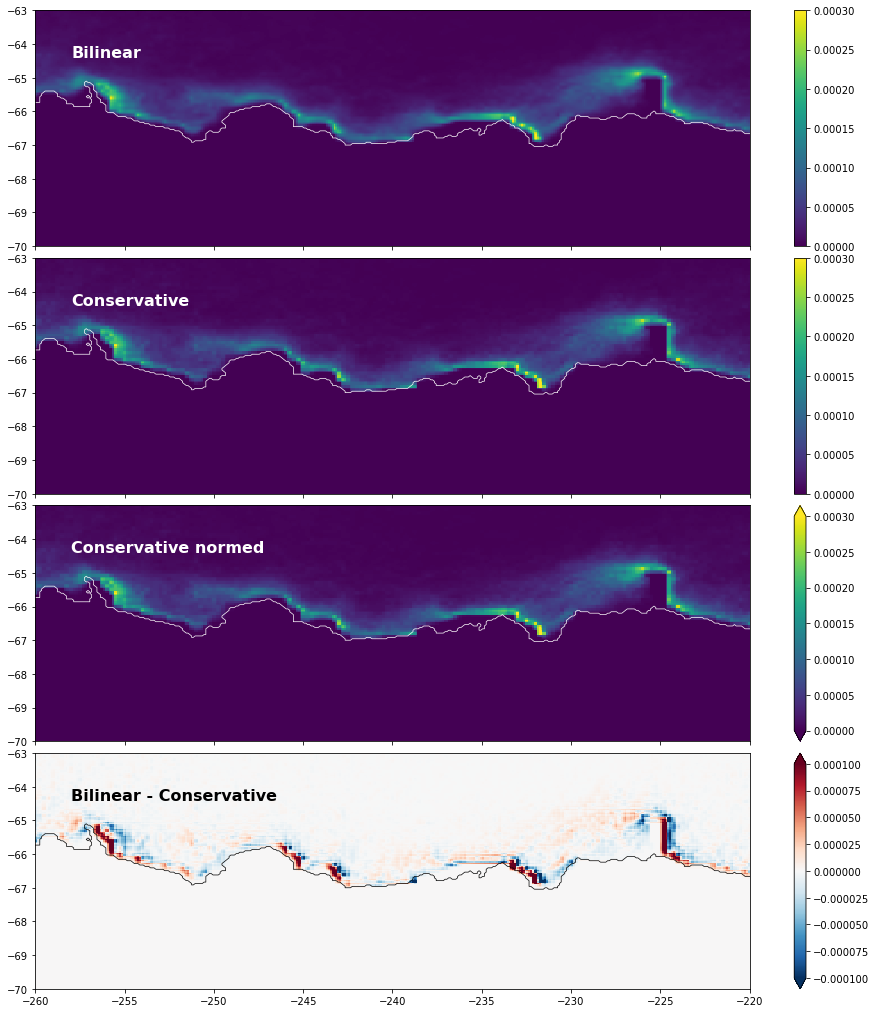

In [51]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,18), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
month = 0

cb = axes[0].pcolormesh(icb_flux_regrid_bi.lon, icb_flux_regrid_bi.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[0].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[0].text(0.05, 0.8, labels[0], c='w', fontweight='bold',fontsize=16., transform=axes[0].transAxes)
fig.colorbar(cb, ax=axes[0])

cb = axes[1].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_cons[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[1].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[1].text(0.05, 0.8, labels[1], c='w', fontweight='bold',fontsize=16., transform=axes[1].transAxes)
fig.colorbar(cb, ax=axes[1])

cb = axes[2].pcolormesh(icb_flux_regrid_cons_norm.lon, icb_flux_regrid_cons_norm.lat, 
                        icb_flux_regrid_cons_norm[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[2].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[2].text(0.05, 0.8, labels[2], c='w', fontweight='bold',fontsize=16., transform=axes[2].transAxes)
fig.colorbar(cb, ax=axes[2], extend='both')

cb = axes[3].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:]-icb_flux_regrid_cons[month,:,:], 
                        vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')
axes[3].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='k', linewidths=0.7)
axes[3].text(0.05, 0.8, labels[3], c='k', fontweight='bold',fontsize=16., transform=axes[3].transAxes)
fig.colorbar(cb, ax=axes[3], extend='both')

axes[0].set_ylim([-70, -63])
axes[0].set_xlim([-260, -220])
plt.show()

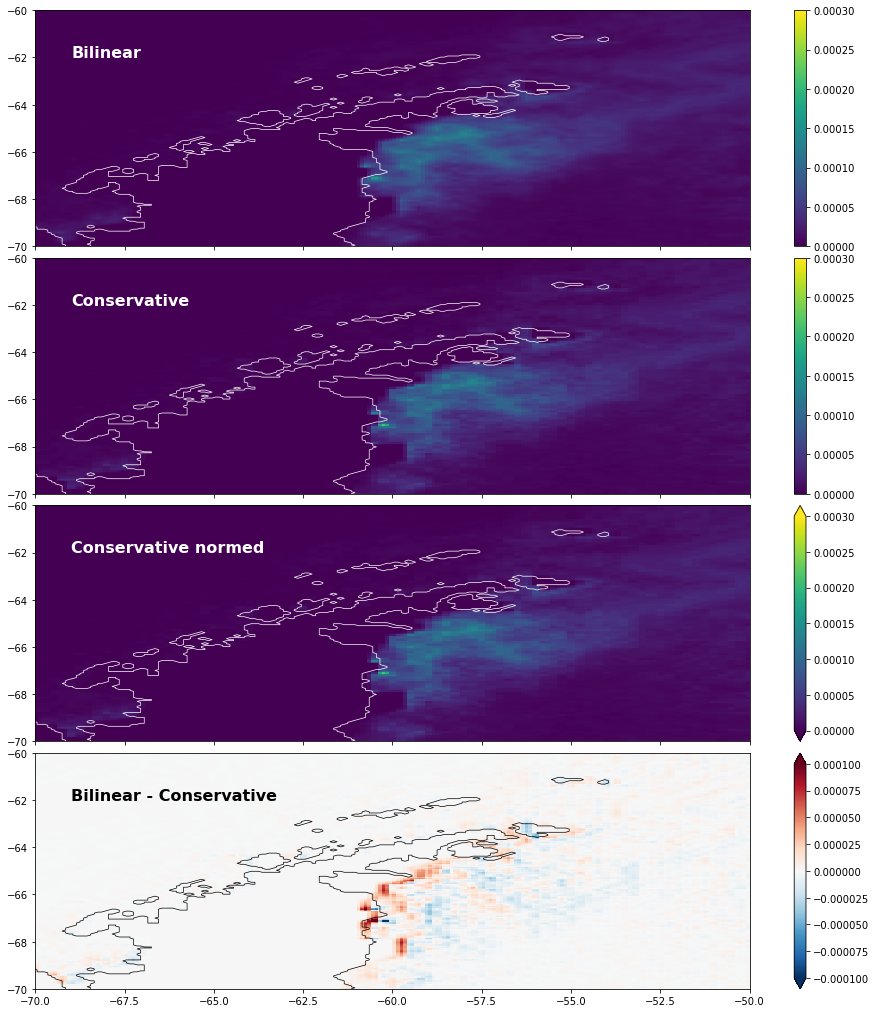

In [52]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,18), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
month = 0

cb = axes[0].pcolormesh(icb_flux_regrid_bi.lon, icb_flux_regrid_bi.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[0].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[0].text(0.05, 0.8, labels[0], c='w', fontweight='bold',fontsize=16., transform=axes[0].transAxes)
fig.colorbar(cb, ax=axes[0])

cb = axes[1].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_cons[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[1].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[1].text(0.05, 0.8, labels[1], c='w', fontweight='bold',fontsize=16., transform=axes[1].transAxes)
fig.colorbar(cb, ax=axes[1])

cb = axes[2].pcolormesh(icb_flux_regrid_cons_norm.lon, icb_flux_regrid_cons_norm.lat, 
                        icb_flux_regrid_cons_norm[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[2].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[2].text(0.05, 0.8, labels[2], c='w', fontweight='bold',fontsize=16., transform=axes[2].transAxes)
fig.colorbar(cb, ax=axes[2], extend='both')

cb = axes[3].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:]-icb_flux_regrid_cons[month,:,:], 
                        vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')
axes[3].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='k', linewidths=0.7)
axes[3].text(0.05, 0.8, labels[3], c='k', fontweight='bold',fontsize=16., transform=axes[3].transAxes)
fig.colorbar(cb, ax=axes[3], extend='both')

axes[0].set_ylim([-70, -60])
axes[0].set_xlim([-70, -50])
plt.show()

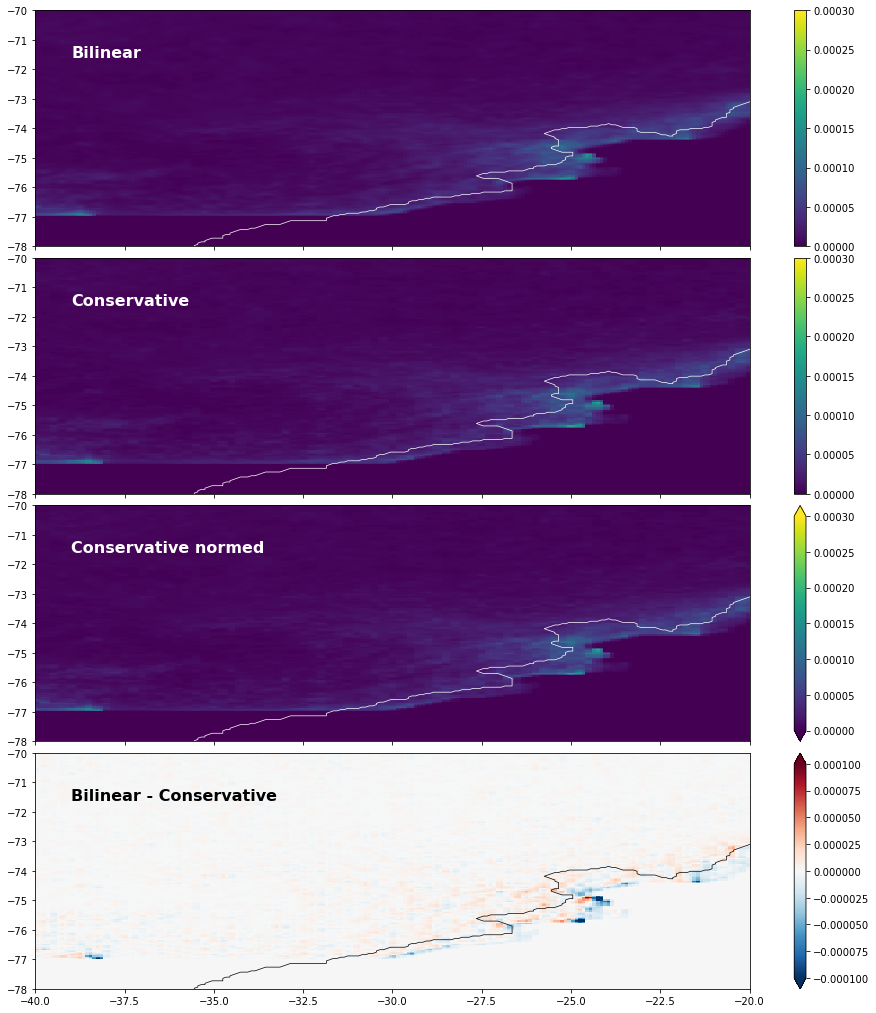

In [54]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,18), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
month = 0

cb = axes[0].pcolormesh(icb_flux_regrid_bi.lon, icb_flux_regrid_bi.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[0].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[0].text(0.05, 0.8, labels[0], c='w', fontweight='bold',fontsize=16., transform=axes[0].transAxes)
fig.colorbar(cb, ax=axes[0])

cb = axes[1].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_cons[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[1].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[1].text(0.05, 0.8, labels[1], c='w', fontweight='bold',fontsize=16., transform=axes[1].transAxes)
fig.colorbar(cb, ax=axes[1])

cb = axes[2].pcolormesh(icb_flux_regrid_cons_norm.lon, icb_flux_regrid_cons_norm.lat, 
                        icb_flux_regrid_cons_norm[month,:,:], 
                        vmin=0, vmax=0.0003)
axes[2].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='w', linewidths=0.7)
axes[2].text(0.05, 0.8, labels[2], c='w', fontweight='bold',fontsize=16., transform=axes[2].transAxes)
fig.colorbar(cb, ax=axes[2], extend='both')

cb = axes[3].pcolormesh(icb_flux_regrid_cons.lon, icb_flux_regrid_cons.lat, 
                        icb_flux_regrid_bi.Icb_flux[month,:,:]-icb_flux_regrid_cons[month,:,:], 
                        vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')
axes[3].contour(ht.xt_ocean, ht.yt_ocean, httmp, levels=[0,1],colors='k', linewidths=0.7)
axes[3].text(0.05, 0.8, labels[3], c='k', fontweight='bold',fontsize=16., transform=axes[3].transAxes)
fig.colorbar(cb, ax=axes[3], extend='both')

axes[0].set_ylim([-78, -71])
axes[0].set_xlim([-40, -20])
plt.show()